# Same Atom Selection
----
- Same chemical context
- Iterate the same context within one frame
----
- Expect minor changes

In [1]:
import open3d as o3d
import time, builtins, tempfile, datetime, os 
import pickle 
from BetaPose import utils, chemtools, representations; 

import pytraj as pt 
import numpy as np 
from scipy.stats import entropy 
from scipy.ndimage import gaussian_filter 
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


from BetaPose import utils, cluster

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Example workflow

from BetaPose import trajloader, data_io
from BetaPose import features, featurizer


# Load multiple trajectories
trajs = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_001_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_002_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_003_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_005_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_006_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_007_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_010_traj.nc%"
tops = ["/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"] * 10
trajs = trajs.strip("%").split("%")
trajectories = trajloader.TrajectoryLoader(trajs, tops); 

for traj in trajectories: 
  # Complete the trajectory information
  try: 
    traj.strip(":T3P")
  except: 
    pass
  print(traj)
  #### traj.addcharge(); 
  
  # Initialize the featurizer since different trajectory might have distinct parameters
  # featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  feature_mass = features.MassFeature(); 
  # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer
  
  featurizer.register_feature(feature_mass)   # i features
  featurizer.register_traj(traj)
  
  # Fit the standardizer of the input features
#   featurizer.register_frames(range(0, 1000, 20))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA,C,N&:2-145"), fbox_length=[6,6,6])
  
  # A lot of frames and centers
#   featurizer.register_frames(range(0, 1000, 50))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:1-145"), fbox_length=[6,6,6])
  
  # Fix the residues atom and iterate different frames
#   featurizer.register_frames(range(0, 1000, 10))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45"), fbox_length=[6,6,6])
  
  # Fix the frame and iterate different resiudes
  featurizer.register_frames([42]) 
  repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45-145"), fbox_length=[6,6,6])

  # Fix the frames, and iterated load one resdiue TODO
#   featurizer.register_frames([60]) 
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45-145"), fbox_length=[6,6,6])
  
  # featurizer.register_centers() # k centers 
  
  print(repr_traji.shape)
  print(fpfh_traji.shape)
  print(features_traji.shape)
#   featurizer.dump("repr_form", repr_traji, "/tmp/test.h5"); 
#   featurizer.dump("FPFH", np.array([(0,d) for d in fpfh_traji], dtype=object), "/tmp/test.h5"); 
  break
  
import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}


# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))
  
write_scalar = False
if write_scalar: 
#   scaler = StandardScaler()
  scaler = RobustScaler(); 
  scaler.fit(repr_traji); 
  pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))
  


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
pytraj.Trajectory, 1001 frames: 
Size: 0.056316 (GB)
<Topology: 2517 atoms, 188 residues, 38 mols, non-PBC>
           
23-05-30T17:30:21   : Parameters are loaded
23-05-30T17:30:21   : SEGMENT_LIMIT: 6 | DOWN_SAMPLE_POINTS: 600 | VIEWPOINT_BINS: 12 | MSMS_EXE: msms_i86_64Linux2_2.6.1/msms.x86_64Linux2.2.6.1
23-05-30T17:30:21   : [6 6 6]
23-05-30T17:30:21   : Frame 42: Generated 101 centers
(101, 144) (101, 33, 600) (101, 1, 12, 12, 12)
(101, 144)
(101, 33, 600)
(101, 1, 12, 12, 12)


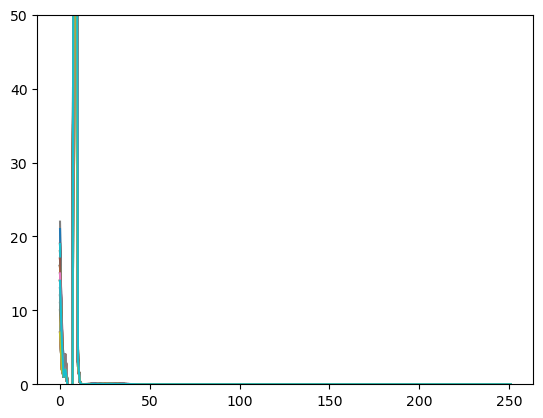

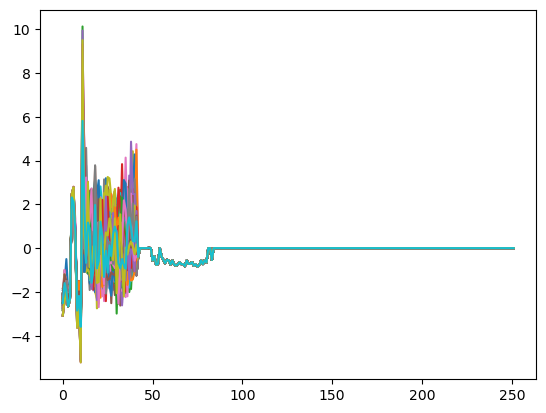

In [2]:
import matplotlib.pyplot as plt 

# write_scalar = True
# if write_scalar: 
#   scaler = StandardScaler()
#   scaler.fit(repr_traji)
#   pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))

plt.plot(repr_traji.T)
plt.ylim([0,50])
plt.show()
plt.plot(pkl_scaled.T)
plt.show()

In [6]:
print(repr_traji[-1].reshape((6,-1)))

representations.compute_similarity(repr_traji[0], repr_traji[-1])

for i, j in enumerate(repr_traji[-1].tolist()):
#   print(i,j)
  pass

[[4.70000000e+01 1.50000000e+01 5.00000000e+00 ... 4.55580866e-03
  7.59301443e-04 2.27790433e-03]
 [4.00000000e+00 2.00000000e+00 0.00000000e+00 ... 2.04081633e-02
  1.53061224e-02 5.10204082e-03]
 [4.00000000e+00 2.00000000e+00 0.00000000e+00 ... 5.12820513e-03
  0.00000000e+00 5.12820513e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Chem contribution   :    1.00  1.00  1.00  0.00  0.00  0.00
VP contribution     :    0.92  0.91  0.91  0.00  0.00  0.00
Weights             :    1.00  0.50  0.15  0.10  0.10  0.05
Contribution(real)  :    0.58  0.29  0.09  0.00  0.00  0.00
Final Similarity    :  0.957573069169434 



Chem contribution   :    1.00  1.00  0.00  0.00  0.00  0.00
VP contribution     :    0.49  1.00  0.00  0.00  0.00  0.00
Weights             :   14.00  0.00  0.00  0.00  0.00  0.00
Contribution(real)  :    0.74  0.00  0.00  0.00  0.00  0.00
Final Similarity    :  0.7433232293656864 

Chem contribution   :    1.00  1.00  0.00  0.00  0.00  0.00
VP contribution     :   -0.03  1.00  0.00  0.00  0.00  0.00
Weights             :   16.00  0.00  0.00  0.00  0.00  0.00
Contribution(real)  :    0.48  0.00  0.00  0.00  0.00  0.00
Final Similarity    :  0.4826085956816768 

Chem contribution   :    1.00  1.00  0.00  0.00  0.00  0.00
VP contribution     :    0.26  1.00  0.00  0.00  0.00  0.00
Weights             :   14.00  0.00  0.00  0.00  0.00  0.00
Contribution(real)  :    0.63  0.00  0.00  0.00  0.00  0.00
Final Similarity    :  0.6277208130168226 

Chem contribution   :    1.00  1.00  0.00  0.00  0.00  0.00
VP contribution     :    0.06  1.00  0.00  0.00  0.00  0.00
Weights             :   14.0

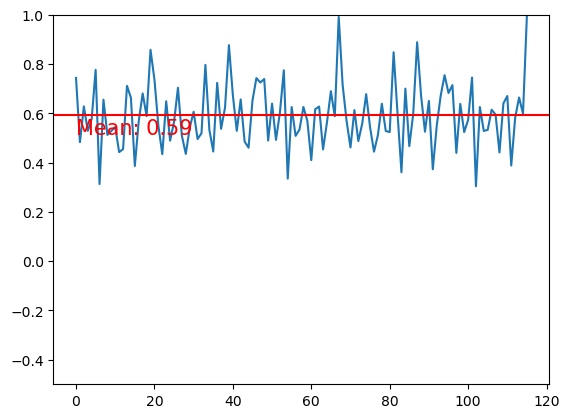

In [7]:
from scipy.spatial import distance
import matplotlib.pyplot as plt 
import numpy as np 
import pickle 

from BetaPose import representations 

# Load the data
with open('TEMP_DATA.pkl', 'rb') as f:
  # Write the object to the file
  thedict = pickle.load(f)
  repr_traji = thedict["repr"]
  
# standardize the data
pkl_model = pickle.load(open("StandardScaler_model.pkl", "rb"))
pkl_scaled = pkl_model.transform(repr_traji)

sims = [representations.compute_similarity(pkl_scaled[-1], pkl_scaled[i], representations.weight(repr_traji[i])) for i in range(len(pkl_scaled))]
print("Mean of similarity values: ", np.mean(sims).round(3))

plt.plot(sims)
plt.axhline(y=np.mean(sims), color="r", linestyle="-")
plt.ylim([-0.5,1])
plt.text(0.02, 0.5, f'Mean: {np.mean(sims):.2f}', verticalalignment='bottom', horizontalalignment='left', color='r', fontsize=15)

plt.show()


# The single residue test 

In [2]:
import time, builtins, tempfile, datetime, os, pickle 

import open3d as o3d
import pytraj as pt 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from BetaPose import trajloader, utils
from BetaPose import features, featurizer, representations

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Load multiple trajectories
trajs = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_001_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_002_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_003_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_005_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_006_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_007_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_010_traj.nc%"
tops = ["/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"] * 10
trajs = trajs.strip("%").split("%")

reslist = range(45, 145)
# reslist = ["SER"]

repr_traji = []
for resid in reslist: 
  trajectories = trajloader.TrajectoryLoader(trajs, tops, mask=f":{resid}"); 
  for traj in trajectories: 
    # Complete the trajectory information
    try: 
      traj.strip(":T3P")
    except: 
      pass
    print(traj.traj)
    
    # Initialize the featurizer since different trajectory might have distinct parameters
    feat   = featurizer.Featurizer3D(FEATURIZER_PARMS); 
    feature_mass = features.MassFeature(); 
    # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer

    feat.register_feature(feature_mass)   # i features
    feat.register_traj(traj)

    print("Processing ====>", list(traj.top.residues)[0])
    # Fix the frame and iterate different resiudes
    feat.register_frames([42]) 
    if isinstance(resid, str): 
      repri, _, _ = feat.run_by_atom(traj.top.select(f"@CA&:{resid}"), fbox_length=[6,6,6])
    else: 
      repri, _, _ = feat.run_by_atom(traj.top.select(f"@CA&:1"), fbox_length=[6,6,6])
    repr_traji += repri.tolist()
    
    break
  
repr_traji = np.asarray(repr_traji)

import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}

# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))  
print("Finished")


pytraj.Trajectory, 1001 frames: 
Size: 0.000380 (GB)
<Topology: 17 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLN44, 17 atoms>
23-05-26T16:06:11   : [6 6 6]
23-05-26T16:06:11   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000492 (GB)
<Topology: 22 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <LYS45, 22 atoms>
23-05-26T16:06:11   : [6 6 6]
23-05-26T16:06:11   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames

DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000246 (GB)
<Topology: 11 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <SER62, 11 atoms>
23-05-26T16:06:14   : [6 6 6]
23-05-26T16:06:14   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000358 (GB)
<Topology: 16 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <VAL63, 16 atoms>
23-05-26T16:06:14   : [6 6 6]
23-05-26T16:06:14   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are

DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000268 (GB)
<Topology: 12 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <ASP80, 12 atoms>
23-05-26T16:06:18   : [6 6 6]
23-05-26T16:06:18   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000157 (GB)
<Topology: 7 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLY81, 7 atoms>
23-05-26T16:06:18   : [6 6 6]
23-05-26T16:06:18   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are k

(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000425 (GB)
<Topology: 19 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <ILE97, 19 atoms>
23-05-26T16:06:21   : [6 6 6]
23-05-26T16:06:21   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000425 (GB)
<Topology: 19 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <LEU98, 19 atoms>
23-05-26T16:06:21   : [6 6 6]
23-05-26T16:06:21   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 1

pytraj.Trajectory, 1001 frames: 
Size: 0.000470 (GB)
<Topology: 21 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <TYR114, 21 atoms>
23-05-26T16:06:25   : [6 6 6]
23-05-26T16:06:25   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000492 (GB)
<Topology: 22 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <LYS115, 22 atoms>
23-05-26T16:06:25   : [6 6 6]
23-05-26T16:06:25   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 fram

pytraj.Trajectory, 1001 frames: 
Size: 0.000336 (GB)
<Topology: 15 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLU131, 15 atoms>
23-05-26T16:06:28   : [6 6 6]
23-05-26T16:06:28   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000537 (GB)
<Topology: 24 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <TRP132, 24 atoms>
23-05-26T16:06:28   : [6 6 6]
23-05-26T16:06:28   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 fram

NameError: name 'fpfh_traji' is not defined

# Rotate of a single residue

# Same Center 
----
- Similar chemical context since trajectory is aligned
- Iterate different frames with one center 
----
- Expect minor changes

# Different Atom Selection
----
- Different chemical context
- Iterate different context within one frame
----
- Expect significant change

# Rotate the protein structure

In [6]:
import open3d as o3d
import time, builtins, tempfile, datetime, os 
import pickle 
from BetaPose import utils, chemtools, representations; 

import pytraj as pt 
import numpy as np 
from scipy.stats import entropy 
from scipy.ndimage import gaussian_filter 
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


from BetaPose import utils, cluster

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Example workflow

from BetaPose import trajloader, data_io
from BetaPose import features, featurizer


# Load multiple trajectories
trajs = "/media/yzhang/MieT5/BetaPose/scripts/transformed.nc"
tops = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"

trajectories = trajloader.TrajectoryLoader(
  trajs, tops,
  mask=":45"
); 

for traj in trajectories: 
  # Complete the trajectory information
  try: 
    traj.strip(":T3P")
  except: 
    pass
  print(traj)
  #### traj.addcharge(); 
  
  # Initialize the featurizer since different trajectory might have distinct parameters
  # featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  feature_mass = features.MassFeature(); 
  # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer
  
  featurizer.register_feature(feature_mass)   # i features
  featurizer.register_traj(traj)
  
  # Fit the standardizer of the input features
#   featurizer.register_frames(range(0, 1000, 20))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA,C,N&:2-145"), fbox_length=[6,6,6])
  
  # Fix the residues atom and iterate different frames
  featurizer.register_frames(range(0, traj.n_frames, 15))
  repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:1"), fbox_length=[8, 8,8])
  
  # featurizer.register_centers() # k centers 
  
  print(repr_traji.shape)
  
import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}


# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))
  
write_scalar = False
if write_scalar: 
#   scaler = StandardScaler()
  scaler = RobustScaler(); 
  scaler.fit(repr_traji); 
  pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))
  


Module Trajectory: Loading trajectory /media/yzhang/MieT5/BetaPose/scripts/transformed.nc with topology /media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb
Module Trajectory: stride: None, frame_indices: None, mask: :45
Module Trajectory: Reassigning the trajectory; 
Module Trajectory: Trajectory loaded in 0.16 seconds
pytraj.Trajectory, 1729 frames: 
Size: 0.000657 (GB)
<Topology: 17 atoms, 1 residues, 1 mols, non-PBC>
           
23-05-29T17:56:01   : [8 8 8]
23-05-29T17:56:01   : Frame 0: Generated 1 centers
23-05-29T17:56:01   : Found 2 segments (array([0, 1]), array([ 3, 14]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:01   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0000000000000002
23-05-29T17:56:01   : Segment 1 / 1: TriangleMesh with 455 points and 906 triangles.
23-05-29T17:56:01   : Final 3D object: 

23-05-29T17:56:02   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0
23-05-29T17:56:02   : Segment 1 / 1: TriangleMesh with 477 points and 950 triangles.
23-05-29T17:56:02   : Final 3D object:  TriangleMesh with 477 points and 950 triangles.
23-05-29T17:56:02   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:02   : Frame 270: Generated 1 centers
23-05-29T17:56:02   : Found 2 segments (array([0, 1]), array([ 1, 16]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:02   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0000000000000004
23-05-29T17:56:02   : Segment 1 / 1: TriangleMesh with 499 points and 994 triangles.
23-05-29T17:56:02   : Final 3D object:  TriangleMesh with 499 points and 994 triangles.
23-05-29T17:56:02   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252

23-05-29T17:56:02   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0000000000000002
23-05-29T17:56:02   : Segment 1 / 1: TriangleMesh with 448 points and 892 triangles.
23-05-29T17:56:02   : Final 3D object:  TriangleMesh with 448 points and 892 triangles.
23-05-29T17:56:02   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:02   : Frame 510: Generated 1 centers
23-05-29T17:56:02   : Found 2 segments (array([0, 1]), array([ 2, 15]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:02   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 0.9999999999999999
23-05-29T17:56:02   : Segment 1 / 1: TriangleMesh with 481 points and 958 triangles.
23-05-29T17:56:02   : Final 3D object:  TriangleMesh with 481 points and 958 triangles.
23-05-29T17:56:02   : Centers 1 ; Feature vector:  (1, 1, 12, 

23-05-29T17:56:03   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 0.9999999999999996
23-05-29T17:56:03   : Segment 1 / 1: TriangleMesh with 502 points and 1000 triangles.
23-05-29T17:56:03   : Final 3D object:  TriangleMesh with 502 points and 1000 triangles.
23-05-29T17:56:03   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:03   : Frame 750: Generated 1 centers
23-05-29T17:56:03   : Found 2 segments (array([0, 1]), array([ 3, 14]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:03   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 0.9999999999999999
23-05-29T17:56:03   : Segment 1 / 1: TriangleMesh with 455 points and 906 triangles.
23-05-29T17:56:03   : Final 3D object:  TriangleMesh with 455 points and 906 triangles.
23-05-29T17:56:03   : Centers 1 ; Feature vector:  (1, 1, 12

23-05-29T17:56:03   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0000000000000002
23-05-29T17:56:03   : Segment 1 / 1: TriangleMesh with 480 points and 956 triangles.
23-05-29T17:56:03   : Final 3D object:  TriangleMesh with 480 points and 956 triangles.
23-05-29T17:56:03   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:03   : Frame 990: Generated 1 centers
23-05-29T17:56:03   : Found 2 segments (array([0, 1]), array([ 1, 16]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:03   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0
23-05-29T17:56:03   : Segment 1 / 1: TriangleMesh with 496 points and 988 triangles.
23-05-29T17:56:03   : Final 3D object:  TriangleMesh with 496 points and 988 triangles.
23-05-29T17:56:03   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252

DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:03   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0
23-05-29T17:56:03   : Segment 1 / 1: TriangleMesh with 462 points and 920 triangles.
23-05-29T17:56:03   : Final 3D object:  TriangleMesh with 462 points and 920 triangles.
23-05-29T17:56:03   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:03   : Frame 1230: Generated 1 centers
23-05-29T17:56:03   : Found 2 segments (array([0, 1]), array([ 3, 14]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:03   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0
23-05-29T17:56:03   : Segment 1 / 1: TriangleMesh with 460 points and 916 triangles.
23-05-29T17:56:03   : Final 3D object:  TriangleMesh with 460 points and 916 trian

DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:04   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0
23-05-29T17:56:04   : Segment 1 / 1: TriangleMesh with 475 points and 946 triangles.
23-05-29T17:56:04   : Final 3D object:  TriangleMesh with 475 points and 946 triangles.
23-05-29T17:56:04   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:04   : Frame 1455: Generated 1 centers
23-05-29T17:56:04   : Found 1 segments (array([1]), array([17]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:04   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0000000000000002
23-05-29T17:56:04   : Segment 1 / 0: TriangleMesh with 507 points and 1010 triangles.
23-05-29T17:56:04   : Final 3D object:  TriangleMesh with 507 points and 

23-05-29T17:56:04   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0
23-05-29T17:56:04   : Segment 1 / 1: TriangleMesh with 436 points and 868 triangles.
23-05-29T17:56:04   : Final 3D object:  TriangleMesh with 436 points and 868 triangles.
23-05-29T17:56:04   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
23-05-29T17:56:04   : Frame 1680: Generated 1 centers
23-05-29T17:56:04   : Found 1 segments (array([1]), array([17]))
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
23-05-29T17:56:04   : Viewpoint: [1000, 0, 0]; Sum of VPC is: 1.0000000000000004
23-05-29T17:56:04   : Segment 1 / 0: TriangleMesh with 511 points and 1018 triangles.
23-05-29T17:56:04   : Final 3D object:  TriangleMesh with 511 points and 1018 triangles.
23-05-29T17:56:04   : Centers 1 ; Feature vector:  (1, 1, 12, 12, 12)
(1, 252) (1

# Viewpoint Feature histogram


In [ ]:
import numpy as np

def compute_vfh(points, normals, viewpoint, bins=45):
  # Compute the centroid
  centroid = np.mean(points, axis=0); 
  # Compute the direction from the centroid to each point
  directions = viewpoint - centroid; 
  # Compute the angles between the directions and the normals
  angles = np.arccos(np.sum(normals * directions, axis=1) / np.linalg.norm(directions, axis=1))
  # Compute the viewpoint component histogram
  vfh_hist_viewpoint, _ = np.histogram(angles, bins=bins, range=(0, np.pi))

  # Compute the Extended FPFH component for each point
  extended_fpfh = np.zeros((len(points), bins))

  for i, (point, normal) in enumerate(zip(points, normals)):
      k_neighbors = np.arange(len(points))
      k_neighbors = k_neighbors[k_neighbors != i]
      extended_fpfh[i] = compute_pfh(points, normals, i, k_neighbors, bins)

  # Compute the Extended FPFH histogram by summing up the histograms for all points
  vfh_hist_extended = np.sum(extended_fpfh, axis=0)

  # Normalize the histograms
  vfh_hist_viewpoint = vfh_hist_viewpoint / np.sum(vfh_hist_viewpoint)
  vfh_hist_extended = vfh_hist_extended / np.sum(vfh_hist_extended)

  # Concatenate the viewpoint and extended histograms to form the VFH
  vfh = np.concatenate((vfh_hist_viewpoint, vfh_hist_extended))

  return vfh


In [3]:
import matplotlib.pyplot as plt 
import time


class VFH(object):
  """
  Parent class for PFH
  """

  def __init__(self, div, nneighbors, rad):
    """
    Pass in parameters
    """
    self._div = div
    self._nneighbors = nneighbors
    self._radius = rad

    self._error_list = []
    self._Rlist = []
    self._tlist = []
    self._pcd = np.array([])
    print("After initializaiton");

  def push_pcd(self, pcd, norm):
    if len(self._pcd) > 0:
      self._pcd = np.vstack(self._pcd, pcd);
      self._norm = np.vstack(self._norm, norm);
    else:
      self._pcd = np.array(pcd);
      self._norm = np.array(norm);
    self.N = len(self._pcd);
    self._kdtree = spatial.KDTree(self._pcd);

  def get_neighbors(self, pq):
    """
    Get k nearest neighbors of the query point pq from pc within the radius using KDTree.

    :param pq: Query point (1D numpy array of shape (3,))
    :param pc: Point cloud (2D numpy array of shape (N, 3))
    :return: Indices of the k nearest neighbors within the radius, distances of the k nearest neighbors
    """

    distances, indices = self._kdtree.query(pq, k=self._nneighbors+1, distance_upper_bound=self._radius)
    # Filter out neighbors with infinite distance (outside the search radius)
    valid_neighbors = np.isfinite(distances)
    indices = indices[valid_neighbors]
    distances = distances[valid_neighbors]
    return distances, indices

  def compute_fpfh(self):
    
    pass
  
  def compute_efpfh(self):
    pcd_center = np.mean(self._pcd, axis=0);

    for point_idx in range(self.N):
      pi = self._pcd[point_idx];
      ni = self._norm[point_idx];
      
      _, neighbor_idx = self.get_neighbors(pi);
      neighbors = neighbor_idx.tolist(); 
      neighbors.remove(point_idx);    # Remove the original query point
      # print(f"#### {len(neighbor_idx)} points queried")
      # print(point_idx, "=>" , neighbors)
      for nb_idx in neighbors: 
        u = self._norm[nb_idx]; 
        v = np.cross(pi-pcd_center, u)
        w = np.cross(u, v)
        dist = np.linalg.norm(vc)

        alpha = np.dot(v, u)
        phi = np.dot(u, vc)
        theta = np.arctan(np.dot(w, u) / np.dot(u, u))
        
  def compute_vpc(self, viewpoint, bins=128): 
    
    # Compute the relative position of the viewpoint to each point in the cloud
    rel_viewpoint = np.asarray(viewpoint) - self._pcd.mean(axis=0)
    print(rel_viewpoint)

    # Normalize the relative viewpoint vectors
    rel_viewpoint_normalized = rel_viewpoint / np.linalg.norm(rel_viewpoint) #[:, np.newaxis]
    print(rel_viewpoint_normalized, rel_viewpoint_normalized.shape)

    # Calculate the angle between the normals and the relative viewpoint vectors
    cos_angles = np.sum(self._norm * rel_viewpoint_normalized, axis=1)
    angles = np.arccos(cos_angles)
    
    print(np.dot(self._norm, rel_viewpoint_normalized))
    for i in self._norm: 
      print(np.dot(i, rel_viewpoint_normalized))

    # Create the viewpoint component histogram
    hist, _ = np.histogram(angles, bins=bins, range=(0, np.pi))

    # Normalize the histogram
    hist_normalized = hist / np.sum(hist)
#     plt.plot(np.arange(len(hist_normalized)), hist_normalized)
#     plt.show()
    return hist_normalized

        


div = 2
nneighbors = 8
rad = 0.8

import open3d as o3d
import numpy as np
from scipy import spatial

mesh = o3d.io.read_triangle_mesh("/media/yzhang/MieT5/BetaPose/tests/test.ply")

pcd = np.array(mesh.vertices)
# [1200:1800]
norms = np.array(mesh.vertex_normals)
# [1200:1800]
print(pcd.shape, norms.shape)

vfh_container = VFH(div, nneighbors, rad)
vfh_container.push_pcd(pcd, norms); 
print(pcd)

# vfh_container.calc_viewpoint([10,10,10])
# vfh_container.testvfh2([10,10,10])
vfh_container.compute_vpc([10,10,10])

# st = time.perf_counter()
# for i in range(1000): 
#   vfh_container.testvfh2([10,10,10])
# print(time.perf_counter() - st); 






(1390, 3) (1390, 3)
After initializaiton
[[26.198 36.691 27.022]
 [26.539 36.543 27.084]
 [27.075 35.093 28.329]
 ...
 [25.278 32.841 25.679]
 [25.278 33.361 25.679]
 [25.159 33.101 26.13 ]]
[-20.25565252 -25.68393525 -18.78254748]
[-0.53701134 -0.68092422 -0.49795685] (3,)
[0.52718426 0.5938493  0.50031737 ... 0.83792112 0.52964206 0.53701134]
0.5271842627685688
0.5938492969508882
0.5003173683467622
0.8732540340468018
0.7816073270795973
0.8173920929446075
0.5668221641191383
0.5322932213596699
0.8792227776861242
-0.021205475849279898
-0.4741820873481106
0.1945349586270783
-0.20987448735078806
-0.7908499102819864
-0.5163115634085433
-0.34434778788964315
-0.7104123318205928
0.5334592254645619
-0.1406797840771912
0.33179730528938844
0.7582596151272685
-0.41936701288798606
-0.00335659706607333
0.24561628415221654
-0.06160551709695791
0.23233380824172234
0.4985848355839647
0.28718537433198266
0.46085053480574456
0.7015156956252413
0.536571099753376
0.43618392046274773
0.5128476647820629
0.4

array([0.        , 0.        , 0.00071942, ..., 0.00071942, 0.        ,
       0.        ])

In [32]:
1/6

0.16666666666666666

[[14.  6.  1. ...  0.  0.  0.]
 [17.  9.  1. ...  0.  0.  0.]
 [11.  5.  1. ...  0.  0.  0.]
 ...
 [14.  6.  1. ...  0.  0.  0.]
 [14.  6.  1. ...  0.  0.  0.]
 [12.  6.  1. ...  0.  0.  0.]]
Processing:  0
[ 1.35595000e+01  5.97800000e+00  1.00000000e+00  2.00000000e+00
  2.01084495e-01 -7.93268092e-01 -8.07682526e+00 -1.14313816e-01
  1.34155161e+02  1.17868234e+02  3.14392231e+00  3.62192500e-01] [1.81147999e+00 1.35000593e+00 0.00000000e+00 0.00000000e+00
 4.57966998e-15 8.15915714e-02 1.51622884e+00 1.83320527e-01
 1.38454564e+01 2.04640994e+01 1.69229373e-01 2.08561182e-02] [ 7.48531592e+00  4.42812871e+00             inf             inf
  4.39080755e+13 -9.72242695e+00 -5.32691704e+00 -6.23573464e-01
  9.68947197e+00  5.75975669e+00  1.85778760e+01  1.73662470e+01]
===>  2000 [14. 17. 11. ... 14. 14. 12.]
Processing:  1
[0.01288986 0.04644799 0.06689245 0.11027039 0.1386359  0.14270247
 0.12668243 0.09642267 0.10455058 0.0754374  0.06164914 0.01741872] [0.00725836 0.01303225 0.0

/tmp/ipykernel_2558460/1881521055.py:14: RuntimeWarning: divide by zero encountered in divide
  SNR = result[:, 0+12*segi:12+12*segi].mean(axis=0)/result[:, 0+12*segi:12+12*segi].std(axis=0)
/tmp/ipykernel_2558460/1881521055.py:14: RuntimeWarning: invalid value encountered in divide
  SNR = result[:, 0+12*segi:12+12*segi].mean(axis=0)/result[:, 0+12*segi:12+12*segi].std(axis=0)


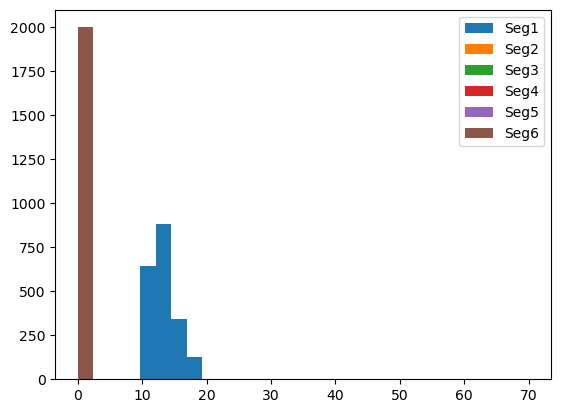

In [1]:
import pickle 
import matplotlib.pyplot as plt 
import numpy as np 


with open("/media/yzhang/MieT5/BetaPose/scripts/TEMP_DATA.pkl", "rb") as f: 
  result_dict = pickle.load(f)
  result = result_dict["repr"]
  print(result)
for segi in range(6): 
  print("Processing: ", segi)
  meani = result[:, 0+12*segi:12+12*segi].mean(axis=0)
  stdi  = result[:, 0+12*segi:12+12*segi].std(axis=0)
  SNR = result[:, 0+12*segi:12+12*segi].mean(axis=0)/result[:, 0+12*segi:12+12*segi].std(axis=0)
  print(meani, stdi, SNR)
  
#   plt.violinplot(result[:, 0+12*segi:12+12*segi], range(12))
  print("===> ", len(result[:, 0+24*segi]), result[:, 0+24*segi])
  plt.hist(result[:, 0+24*segi], bins=np.linspace(0, 70, 30))
  
# plt.ylim([-0,1])
plt.legend([f"Seg{i+1}" for i in range(6)])
plt.show()

(112776, 144) 112800
(112800, 144)
Mean Viewpoint:  ['0.02', '0.06', '0.08', '0.10', '0.11', '0.13', '0.13', '0.11', '0.10', '0.08', '0.06', '0.02']
Ratio Mean/Std:  ['2.66', '4.56', '6.66', '6.46', '6.56', '6.95', '6.85', '6.55', '6.54', '6.69', '4.51', '2.60']
Mean Structure:  ['43.95', '14.73', '5.11', '9.85', '1.66', '-3.25', '-24.84', '-1.02', '338.29', '404.29', '4.73', '0.23']
Ratio Mean/Std:  ['4.80', '3.94', '3.08', '4.38', '3.98', '-4.43', '-4.27', '-0.63', '6.35', '4.20', '14.55', '10.59']
0 12


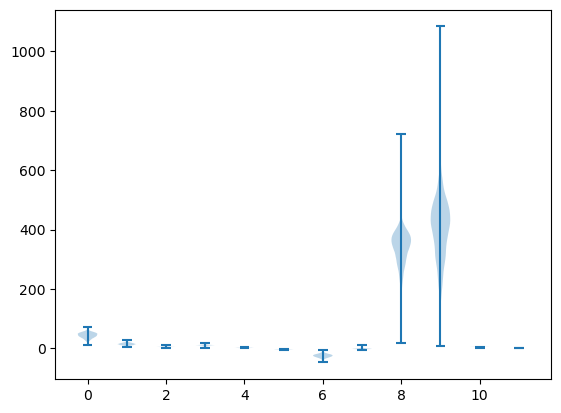

In [49]:
result = result_dict["repr"]
result_gt0 = result[result[:,0]>0]
print(result_gt0.shape, len(result))

print(result.shape)
print("Mean Viewpoint: ", [f"{i:.2f}" for i in result_gt0[:,12:24].mean(axis=0)])
print("Ratio Mean/Std: ", [f"{i:.2f}" for i in result_gt0[:,12:24].mean(axis=0) / result_gt0[:,12:24].std(axis=0)])
print("Mean Structure: ", [f"{i:.2f}" for i in result_gt0[:,:12].mean(axis=0)])
print("Ratio Mean/Std: ", [f"{i:.2f}" for i in result_gt0[:,:12].mean(axis=0) / result_gt0[:,:12].std(axis=0)])

whichseg = 0
part = 0
col_st = part+whichseg*12
col_ed = part+12+whichseg*12
print(col_st, col_ed)
plt.violinplot(result_gt0[:, col_st:col_ed], range(12))
# plt.ylim([-0,1])
plt.show()

(2000, 144)
Seg1
Range EQ 0         ,      0/2000, 0.000
Range IN (1, 5)    ,      0/2000, 0.000
Range IN (5, 15)   ,   1527/2000, 0.763
Range IN (15, 35)  ,    473/2000, 0.236
Range IN (35, 55)  ,      0/2000, 0.000
Range GE 55        ,      0/2000, 0.000
Seg2
Range EQ 0         ,   2000/2000, 1.000
Range IN (1, 5)    ,      0/2000, 0.000
Range IN (5, 15)   ,      0/2000, 0.000
Range IN (15, 35)  ,      0/2000, 0.000
Range IN (35, 55)  ,      0/2000, 0.000
Range GE 55        ,      0/2000, 0.000
Seg3
Range EQ 0         ,   2000/2000, 1.000
Range IN (1, 5)    ,      0/2000, 0.000
Range IN (5, 15)   ,      0/2000, 0.000
Range IN (15, 35)  ,      0/2000, 0.000
Range IN (35, 55)  ,      0/2000, 0.000
Range GE 55        ,      0/2000, 0.000
Seg4
Range EQ 0         ,   2000/2000, 1.000
Range IN (1, 5)    ,      0/2000, 0.000
Range IN (5, 15)   ,      0/2000, 0.000
Range IN (15, 35)  ,      0/2000, 0.000
Range IN (35, 55)  ,      0/2000, 0.000
Range GE 55        ,      0/2000, 0.000
Seg5
Ran

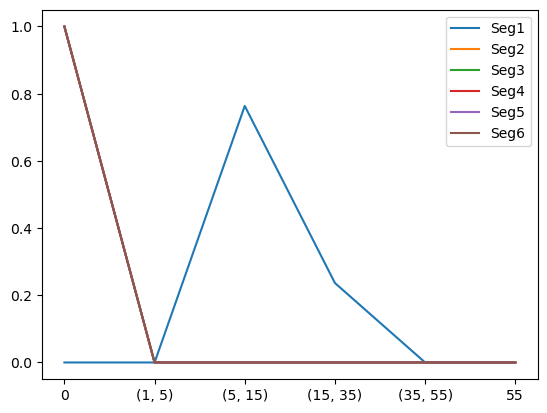

In [3]:
import numpy as np 


print(result.shape)

# arr_mass = result.reshape((len(result)*6, -1))[:,0]; 
# slices = [0,   (1 , 11),   (11, 21),   (21, 31),   (31, 41),   (41, 51),   51]
slices = [0,   (1 , 4), (4, 21),   (21, 41),   (41, 51),   51]
slices = [0,   (1 , 5), (5, 15),   (15, 35),   (35, 55),   55]
def count_by_slices(arr): 
  final_result = []
  for s in slices: 
    if isinstance(s, (tuple, list)): 
      stat = np.asarray(arr >= s[0]) * np.asarray(arr < s[1]); 
      print(f"Range IN {s.__str__():<10}, {np.count_nonzero(stat):6d}/{len(arr)}, {np.count_nonzero(stat)/len(arr):.3f}"); 
    elif isinstance(s, (int, float)): 
      if s == 0: 
        stat = np.asarray(arr == 0); 
        print(f"Range EQ {s.__str__():<10}, {np.count_nonzero(stat):6d}/{len(arr)}, {np.count_nonzero(stat)/len(arr):.3f}"); 

      elif s > 0: 
        stat = np.asarray(arr >= s); 
        print(f"Range GE {s.__str__():<10}, {np.count_nonzero(stat):6d}/{len(arr)}, {np.count_nonzero(stat)/len(arr):.3f}"); 
    final_result.append(np.count_nonzero(stat)/len(arr))
  return  final_result



final_distribution = np.zeros((len(slices),6))

for segi in range(6): 
  print(f"Seg{segi+1}")
  whichsegment = segi
  arr_mass = result[:, 0+24*whichsegment:12+24*whichsegment].reshape((len(result), -1))[:,0]; 
  ret = count_by_slices(arr_mass)
  final_distribution[:,segi] = ret
print(final_distribution)

print([i.__str__() for i in slices])
print([f"{i:4.3f}" for i in final_distribution.sum(axis=1)])
print(final_distribution.sum(axis=1)[1:].sum())
print("Finished it ")

plt.plot(final_distribution)
plt.xticks(ticks = range(len(slices)), labels = [i.__str__() for i in slices])
plt.legend([f"Seg{i}" for i in range(1,len(slices)+2)])

# for i in range(24): 
#   fig, ax = plt.subplots()
#   ax.hist(result.reshape((len(result)*6, -1))[:,i])
#   ax.set_title(f"FIG{i}")
#   fig.show()



[[14.  6.  1. ...  0.  0.  0.]
 [17.  9.  1. ...  0.  0.  0.]
 [11.  5.  1. ...  0.  0.  0.]
 ...
 [40. 13.  3. ...  0.  0.  0.]
 [35. 11.  4. ...  0.  0.  0.]
 [37. 11.  5. ...  0.  0.  0.]]
[14.  0.  0. ...  0.  0.  0.]
Seg(1, 5)
Range IN (1, 5)    ,  97198/688656, 0.141
[False False False ... False False False]
[1. 2. 3. ... 1. 1. 2.]
Mean [ 2.03940410e+00  3.55593736e-01  1.01298381e-01  1.86938003e-01
  9.93907206e-03 -8.30645646e-02 -4.93437848e-01 -1.33133818e-02
  3.29110686e+01  1.70131014e+01  1.57645287e+00  7.17945585e-01
  1.60309482e-02  7.72778591e-02  3.68806052e-02  1.39571226e-01
  5.84839300e-02  1.69893166e-01  1.72346468e-01  5.92059101e-02
  1.40538937e-01  3.61678995e-02  7.75688359e-02  1.60342153e-02] (24,)
Std  [1.11045142e+00 5.79815549e-01 3.05518564e-01 4.18817747e-01
 4.55439349e-02 1.48304775e-01 9.74855948e-01 1.04398411e-01
 1.56029606e+01 1.09947796e+01 3.95605514e-01 1.42487893e-01
 8.72371748e-03 2.14613009e-02 3.58691460e-02 3.27323720e-02
 5.863591

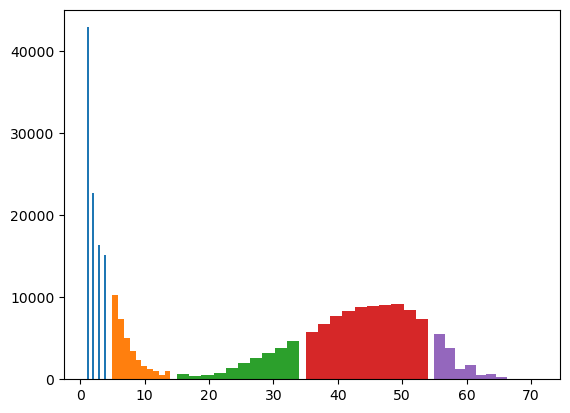

In [18]:
import json, pickle
import numpy as np 
import matplotlib.pyplot as plt 

with open("/media/yzhang/MieT5/BetaPose/scripts/merged.pkl", "rb") as f: 
  result_dict = pickle.load(f)
  result = result_dict["repr"]
  print(result)

def stat_slicei(arr, s): 
  if isinstance(s, (tuple, list)): 
    stat = np.asarray(arr >= s[0]) * np.asarray(arr < s[1]); 
    print(f"Range IN {s.__str__():<10}, {np.count_nonzero(stat):6d}/{len(arr)}, {np.count_nonzero(stat)/len(arr):.3f}"); 
  elif isinstance(s, (int, float)): 
    if s == 0: 
      stat = np.asarray(arr == 0); 
      print(f"Range EQ {s.__str__():<10}, {np.count_nonzero(stat):6d}/{len(arr)}, {np.count_nonzero(stat)/len(arr):.3f}"); 
    elif s > 0: 
      stat = np.asarray(arr >= s); 
      print(f"Range GE {s.__str__():<10}, {np.count_nonzero(stat):6d}/{len(arr)}, {np.count_nonzero(stat)/len(arr):.3f}"); 
  return stat

def standardizer_parms(dataset):
  return dataset.mean(axis=0), dataset.std(axis=0)

# Pre-defined ranges
slices = [0,   (1 , 5), (5, 15),   (15, 35),   (35, 55),   (55, 9999)]
# All-segment-in-one array 
arr_all = result.reshape((len(result)*6, -1))
arr_mass = arr_all[:,0]; 
print(arr_mass)
slices.remove(0)

result_dict = {
  "standardizers": [
    {
      "name": "scalar_set1",
      "dimensions": {
        "slices": slices,
        "box_length": 6,
        "structural_length": 12,
        "viewpoint_length": 12
      },
      "parameters": []
    }
  ]
}


for c, segi in enumerate(slices): 
  print(f"Seg{segi}"); 
  whichsegment = segi; 
  stat_segi = stat_slicei(arr_mass, segi); 
  print(stat_segi)
  print(arr_mass[stat_segi])
  if segi != 0: 
    plt.hist(arr_mass[stat_segi])
    _mean, _std = standardizer_parms(arr_all[stat_segi])
    parami = {
      "range": list(segi), 
      "mean": [float(i) for i in _mean],
      "std": [float(i) for i in _std ]
    }
    result_dict["standardizers"][0]["parameters"].append(parami)
    print("Mean", _mean, _mean.shape)
    print("Std ", _std, _std.shape)
#     fig,ax = plt.subplots()
#     ax.hist(arr_mass[stat_segi])
with open("/media/yzhang/MieT5/BetaPose/scripts/merged.json", "w") as file1: 
  json.dump(result_dict, file1, indent=2)

  
  

# Merge multiple pkl fingerprint files

In [22]:
import pickle, json
import numpy as np 

files = "/media/yzhang/MieT5/BetaPose/scripts/TEMP_DATA.pkl%/media/yzhang/MieT5/BetaPose/scripts/REPR_aBB_r141_f20_l6.pkl%"
filelst = files.strip("%").split("%")
print(filelst)

all_data = np.array([])
for idx,filename in enumerate(filelst): 
  with open(filename, "rb") as file1: 
    thedict = pickle.load(file1)
#     print(dir(thedict))
    result = thedict["repr"]
    print(len(result))
    result = result[result[:,0] != 0]
    print(len(result))
    if idx == 0: 
      all_data = result; 
    else: 
      all_data = np.concatenate((all_data, result)); 

with open("/media/yzhang/MieT5/BetaPose/scripts/merged.pkl", "wb") as file1: 
  print(len(all_data))
  output_data = {"repr":all_data}; 
  pickle.dump(output_data, file1); 







['/media/yzhang/MieT5/BetaPose/scripts/TEMP_DATA.pkl', '/media/yzhang/MieT5/BetaPose/scripts/REPR_aBB_r141_f20_l6.pkl']
24500
24500
112800
112776
137276


In [20]:
processed = [231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,294,295,296,297,298,299,300,301,302,303,304,305,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,273,274,275,276,277,278,279,280,281,282,283,284,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,357,358,359,360,361,362,363,364,365,366,367,368,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,336,337,338,339,340,341,342,343,344,345,346,347,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,315,316,317,318,319,320,321,322,323,324,325,326,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,441,442,443,444,445,446,447,448,449,450,451,452,210,211,212,213,214,215,216,217,218,219,220,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,504,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,462,463,464,465,466,467,468,469,470,471,472,473,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,378,379,380,381,382,383,384,385,386,387,388,389,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,399,400,401,402,403,404,405,406,407,408,409,410,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,420,421,422,423,424,425,426,427,428,429,430,431,306,307,308,309,310,311,312,313,314,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,840,841,842,327,328,329,330,331,332,333,334,335,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,819,820,821,348,349,350,351,352,353,354,355,356,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,861,862,863,453,454,455,456,457,458,459,460,461,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,882,883,884,369,370,371,372,373,374,375,376,377,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,903,904,905,411,412,413,414,415,416,417,418,419,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,945,946,947,285,286,287,288,289,290,291,292,293,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,924,925,926,474,475,476,477,478,479,480,481,482,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,966,967,968,432,433,434,435,436,437,438,439,440,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,987,988,989,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,777,778,779,780,781,782,783,784,785,786,787,788,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,798,799,800,801,802,803,804,805,806,807,808,809,789,790,791,792,793,794,795,796,797,810,811,812,813,814,815,816,817,818,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,990,991,992,993,994,995,996,997,998,999,390,391,392,393,394,395,396,397,398,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,]

started = [231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,294,295,296,297,298,299,300,301,302,303,304,305,306,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,273,274,275,276,277,278,279,280,281,282,283,284,285,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,357,358,359,360,361,362,363,364,365,366,367,368,369,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,336,337,338,339,340,341,342,343,344,345,346,347,348,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,315,316,317,318,319,320,321,322,323,324,325,326,327,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,441,442,443,444,445,446,447,448,449,450,451,452,453,210,211,212,213,214,215,216,217,218,219,220,221,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,504,505,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,462,463,464,465,466,467,468,469,470,471,472,473,474,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,378,379,380,381,382,383,384,385,386,387,388,389,390,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,399,400,401,402,403,404,405,406,407,408,409,410,411,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,420,421,422,423,424,425,426,427,428,429,430,431,432,307,308,309,310,311,312,313,314,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,840,841,842,843,328,329,330,331,332,333,334,335,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,819,820,821,822,349,350,351,352,353,354,355,356,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,861,862,863,864,454,455,456,457,458,459,460,461,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,882,883,884,885,370,371,372,373,374,375,376,377,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,903,904,905,906,412,413,414,415,416,417,418,419,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,945,946,947,948,286,287,288,289,290,291,292,293,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,924,925,926,927,475,476,477,478,479,480,481,482,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,966,967,968,969,433,434,435,436,437,438,439,440,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,987,988,989,990,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,777,778,779,780,781,782,783,784,785,786,787,788,789,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,798,799,800,801,802,803,804,805,806,807,808,809,810,790,791,792,793,794,795,796,797,811,812,813,814,815,816,817,818,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,991,992,993,994,995,996,997,998,999,391,392,393,394,395,396,397,398,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,]
for i in processed: 
  if i in started: 
    started.remove(i)
  else: 
    print("NON", i)
  
print(started)


[221, 505]
